# Imports and data loading

In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import sys

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from typing import Optional

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=True

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='1'

set_seed(0)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

In [3]:
anndataset_10k = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_5k = anndata.read(save_path + "pbmc_5k_protein_v3.h5ad")

In [4]:
adata_hvg = anndata.AnnData.concatenate(anndataset_10k, anndataset_5k)
seurat_v3_highly_variable_genes(adata_hvg)
global_high_var_genes = adata_hvg.var.index[adata_hvg.var["highly_variable"]]

anndataset_10k = anndataset_10k[:, adata_hvg.var.index]
anndataset_5k = anndataset_5k[:, adata_hvg.var.index]

(15792,)
(6855, 15792)
(15792,)
(3994, 15792)


In [5]:
dataset_10k = AnnDatasetFromAnnData(ad = anndataset_10k[:, global_high_var_genes])
protein_data_10k = CellMeasurement(name="protein_expression", data=anndataset_10k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_10k.uns["protein_names"])
dataset_10k.initialize_cell_measurement(protein_data_10k)

dataset_5k = AnnDatasetFromAnnData(ad = anndataset_5k[:, global_high_var_genes])
protein_data_5k = CellMeasurement(name="protein_expression", data=anndataset_5k.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset_5k.uns["protein_names"])
dataset_5k.initialize_cell_measurement(protein_data_5k)

[2020-04-22 17:31:09,976] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:09,979] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:10,026] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:10,073] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-04-22 17:31:10,201] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:10,203] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:10,231] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:10,258] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


In [6]:
# This modifies original datasets in place and intersects protein columns
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [dataset_10k, dataset_5k],
)

[2020-04-22 17:31:10,323] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-04-22 17:31:10,402] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:10,493] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:10,495] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:10,537] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:10,585] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:10,587] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:10,834] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:10,837] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:10,839] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


## Mask out 5k proteins

In [7]:
fiveK_proteins = dataset_5k.protein_expression.copy()
dataset_5k.protein_expression = np.zeros_like(dataset_5k.protein_expression)
dataset = GeneExpressionDataset()
dataset.populate_from_datasets(
    [dataset_10k, dataset_5k],
)

[2020-04-22 17:31:10,965] INFO - scvi.dataset.dataset | Keeping 4000 genes
[2020-04-22 17:31:11,004] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:11,096] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:11,099] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:11,124] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-22 17:31:11,172] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:11,174] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:11,420] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-22 17:31:11,423] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-22 17:31:11,426] INFO - scvi.dataset.dataset | Keeping 14 columns in protein_expression


## Run model with masked out 5k

In [8]:
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

In [9]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_batch=dataset.n_batches,
    protein_batch_mask=batch_mask,
    encoder_batch=True
)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
    use_adversarial_loss=True,
    kappa=None,
)
trainer.train(lr=lr, n_epochs=500)

[2020-04-22 17:43:23,681] INFO - scvi.inference.trainer | Reducing LR on epoch 408.
[2020-04-22 17:44:29,175] INFO - scvi.inference.trainer | Reducing LR on epoch 449.
[2020-04-22 17:44:53,644] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-22 17:44:53,645] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


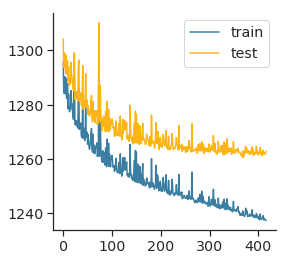

In [10]:
# plt.plot(trainer.history['elbo_validation_set'][50:], label="validation")
plt.plot(trainer.history['elbo_train_set'][50:], label="train")
plt.plot(trainer.history['elbo_test_set'][50:], label="test")
# plt.ylim(2500, 2600)
sns.despine()
plt.legend()

In [11]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# Number of Monte Carlo samples to average over
n_samples = 25

parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=0
)

In [12]:
protein_means = full_posterior.sequential().get_protein_mean(n_samples=25, transform_batch=0)

In [13]:
imputed_proteins = protein_means[dataset.batch_indices.ravel() == 1]

In [14]:
errors = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
corrs = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])
pear_corrs = pd.DataFrame(index = [p.split("_")[0] for p in dataset.protein_names], columns=["totalVI", "Seurat v3"])

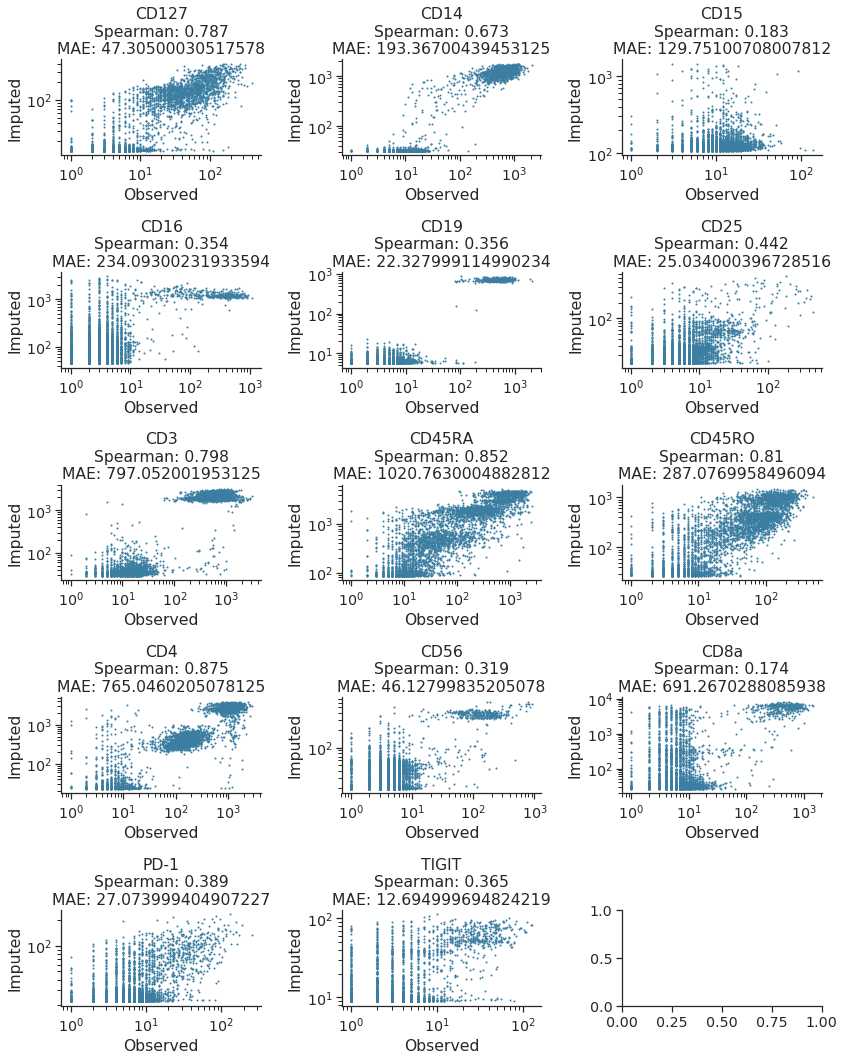

In [15]:
from scipy.stats import pearsonr, spearmanr

fig, axarr = plt.subplots(5, 3, figsize=(12, 15))
for i in range(len(dataset.protein_names)):
    axarr.flat[i].scatter(
        fiveK_proteins[:, i] + 1, imputed_proteins[:, i] + 1, s=1
    )
    axarr.flat[i].set_yscale('log')
    axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(imputed_proteins[:, i], fiveK_proteins[:, i])[
        0
    ]
    p_corr = pearsonr(np.log1p(imputed_proteins[:, i]), np.log1p(fiveK_proteins[:, i]))[
        0
    ]
    mae = np.round(np.mean(
        np.abs(imputed_proteins[:, i] - fiveK_proteins[:, i])
    ), 3)
    corrs.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = p_corr

    errors.loc[dataset.protein_names[i].split("_")[0], "totalVI"] = mae
    axarr.flat[i].set_title(
        dataset.protein_names[i].split("_")[0]
        + "\nSpearman: {}\nMAE: {}".format(np.round(s_corr, 3), mae)
    )
    axarr.flat[i].set_xlabel("Observed")
    axarr.flat[i].set_ylabel("Imputed")
plt.tight_layout()
sns.despine()
plt.tight_layout()

In [16]:
post_adata = anndata.AnnData(X=denoised_genes)
post_adata.var.index = dataset.gene_names
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=40)
sc.tl.umap(post_adata, min_dist=0.2)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.9)
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{} Protein".format(p)] = denoised_proteins[:, i]
    post_adata.obs["{} Protein mean".format(p)] = protein_means[:, i]
post_adata.obs["batch_indices"] = dataset.batch_indices
d_names = ["PBMC-10k", "PBMC-5k (held-out proteins)"]
post_adata.obs["batch_indices"] = [d_names[b[0]] for b in dataset.batch_indices]

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


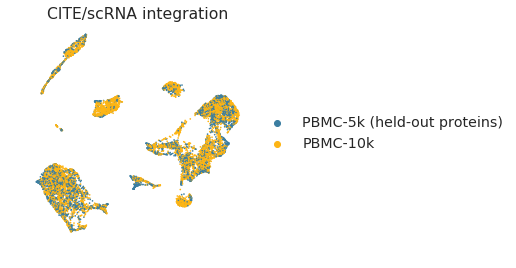

In [17]:
perm_inds = np.random.permutation(len(post_adata))
fig = sc.pl.umap(
    post_adata[perm_inds], 
    color=["batch_indices"],
    title="CITE/scRNA integration",
    return_fig=True,
    frameon=False
)
plt.savefig("figures/pbmc_cite_scrna.pdf", dpi=DPI, bbox_inches="tight")

### save data for Seurat

In [18]:
# batch_0_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.gene_names,
#     columns=anndataset_10k.obs.index,
#     dtype=np.float32,
# )
# batch_0_pro = pd.DataFrame(
#     dataset.protein_expression[dataset.batch_indices.ravel() == 0].T,
#     index=dataset.protein_names,
#     columns=anndataset_10k.obs.index,
#     dtype=np.float32,
# )

# batch_1_rna = pd.DataFrame(
#     dataset.X[dataset.batch_indices.ravel() == 1].T,
#     index=dataset.gene_names,
#     columns=anndataset_5k.obs.index,
#     dtype=np.float32,
# )

# save_path_csv = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/raw_data/"

# batch_0_rna.to_csv(save_path_csv + "pbmc10k_harmo_rna.csv.gz")
# batch_0_pro.to_csv(save_path_csv + "pbmc10k_harmo_pro.csv.gz")
# batch_1_rna.to_csv(save_path_csv + "pbmc5k_harmo_rna.csv.gz")

### Load seurat imputed

In [19]:
seurat_imputed = pd.read_csv(
    "/data/yosef2/users/adamgayoso/projects/totalVI_journal/harmonization/seurat_harmo_results/imputed_pbmc.csv", 
    index_col=0,
).transpose()

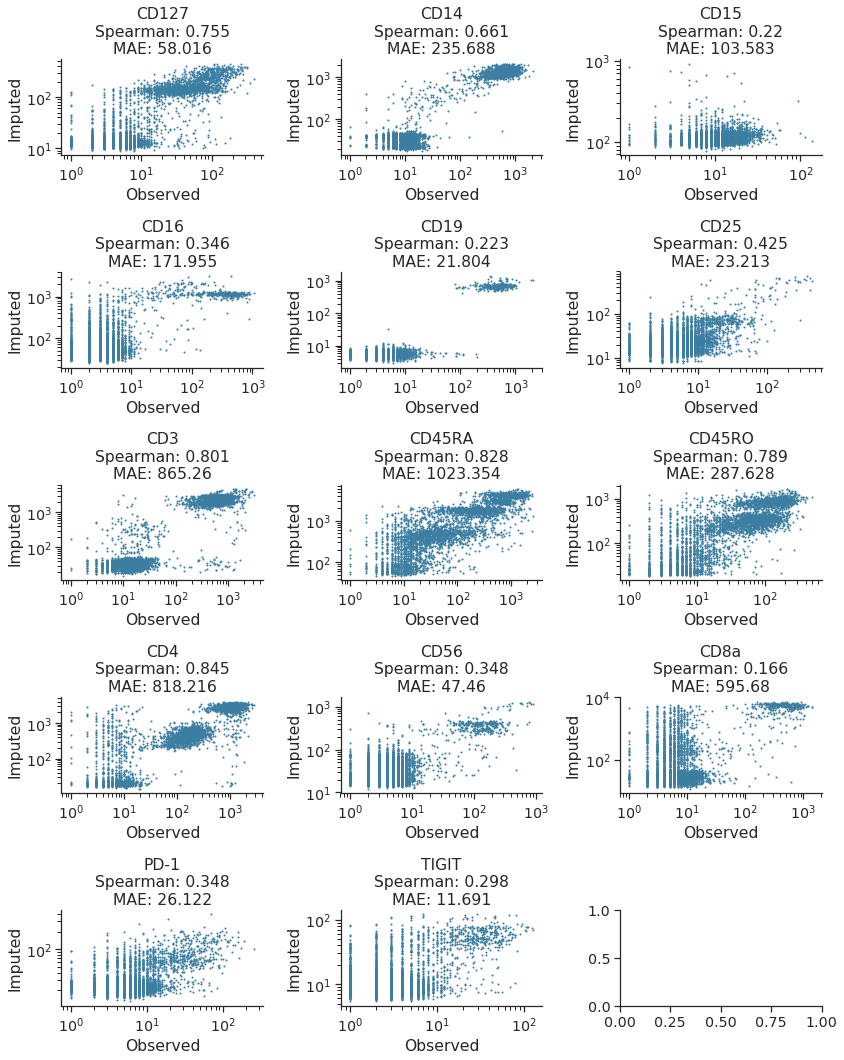

In [20]:
fig, axarr = plt.subplots(5,3, figsize=(12,15))
for i in range(len(dataset.protein_names)):
    axarr.flat[i].scatter(
        fiveK_proteins[:, i] + 1,
        seurat_imputed.iloc[:, i] + 1,
        s=1,
    )
    axarr.flat[i].set_yscale('log')
    axarr.flat[i].set_xscale('log')
    s_corr = spearmanr(
        seurat_imputed.iloc[:, i], fiveK_proteins[:, i]
    )[0]
    p_corr = pearsonr(
        np.log1p(seurat_imputed.iloc[:, i]), np.log1p(fiveK_proteins[:, i])
    )[0]
    mae = np.round(np.mean(np.abs(
        fiveK_proteins[:, i] - seurat_imputed.iloc[:, i]
    )), 3)
    errors.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = mae
    corrs.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = s_corr
    pear_corrs.loc[dataset.protein_names[i].split("_")[0], "Seurat v3"] = p_corr

    axarr.flat[i].set_title(
        dataset.protein_names[i].split("_")[0]
        + "\nSpearman: {}\nMAE: {}".format(np.round(s_corr, 3), mae)
    )
    axarr.flat[i].set_xlabel("Observed")
    axarr.flat[i].set_ylabel("Imputed")
plt.tight_layout()
sns.despine()
plt.tight_layout()

In [21]:
colors = ["#3B7EA1", "#859438", "#FDB515", "#D9661F", "#EE1F60", "#00A598"]
sns.set_palette(sns.color_palette(colors))

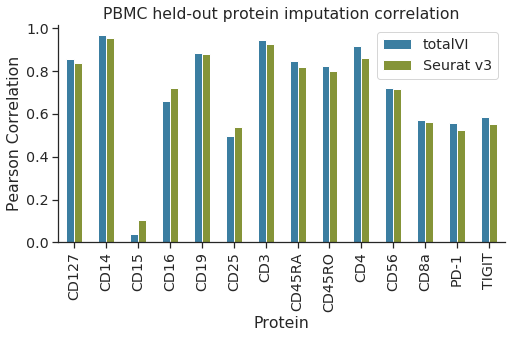

In [22]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(8, 4))
    pear_corrs.plot(kind="bar", ax=ax)
    ax.set_ylabel("Pearson Correlation")
    ax.set_xlabel("Protein")
    plt.legend(fancybox=True)
    ax.set_title("PBMC held-out protein imputation correlation")
    sns.despine()
    fig.savefig("figures/pbmc_imputation_correlation_pearson.pdf", bbox_inches="tight")